In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q SentencePiece transformers[sentencepiece]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.1 MB/s eta 0:00:00


In [3]:
import torch
from transformers import T5EncoderModel, T5Tokenizer
import re
import numpy as np
import gc

In [4]:
tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50", do_lower_case=False )

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [5]:
model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50")

pytorch_model.bin:   0%|          | 0.00/11.3G [00:00<?, ?B/s]

In [6]:
gc.collect()

86

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
model = model.eval()

In [15]:
device

device(type='cuda', index=0)

In [8]:
import pandas as pd
dataset = pd.read_csv('/content/drive/MyDrive/TCREpitopePairs.csv')

In [9]:
dataset.head(5)

,epi,tcr,binding
0,EAAGIGILTV,CASSLGNEQF,1
1,EAAGIGILTV,CASSLGVATGELF,1
2,EAAGIGILTV,CASSQEEGGGSWGNTIYF,1
3,EAAGIGILTV,CASSQEGLAGASQYF,1
4,EAAGIGILTV,CASSQETDIVFNOPQHF,1


In [29]:
sequences = list(dataset["tcr"])
sequences = [re.sub(r"[UZOBX]", "<unk>", sequence) for sequence in sequences]
sequences = [" ".join(s) for s in sequences]
features = []
batchsize = 10**3
currIndex = 0
while currIndex < len(sequences)//100:
  print(currIndex)
  ids = tokenizer.batch_encode_plus(sequences[currIndex:currIndex+batchsize], add_special_tokens=True, padding=True)
  input_ids = torch.tensor(ids['input_ids']).to(device)
  attention_mask = torch.tensor(ids['attention_mask']).to(device)
  with torch.no_grad():
      embedding = model(input_ids=input_ids,attention_mask=attention_mask)
  embedding = embedding.last_hidden_state.cpu().numpy()
  for seq_num in range(len(embedding)):
      seq_len = (attention_mask[seq_num] == 1).sum()
      seq_emd = embedding[seq_num][:seq_len-1]
      seq_emd = np.mean(seq_emd, axis=0)
      features.append(seq_emd)
  currIndex += batchsize

0
1000
2000


In [31]:
features[10**3+4]

array([ 0.17800456,  0.02093581, -0.12081499, ...,  0.0791218 ,
       -0.02517143, -0.02411945], dtype=float32)

In [ ]:
sequences = list(dataset["epi"])
sequences = [re.sub(r"[UZOBX]", "<unk>", sequence) for sequence in sequences]
features_epi = []
batchsize = 10**4
currIndex = 0
while currIndex < len(sequences):
  print(currIndex)
  ids = tokenizer.batch_encode_plus(sequences[currIndex:currIndex+batchsize], add_special_tokens=True, padding=True)
  input_ids = torch.tensor(ids['input_ids']).to(device)
  attention_mask = torch.tensor(ids['attention_mask']).to(device)
  with torch.no_grad():
      embedding = model(input_ids=input_ids,attention_mask=attention_mask)
  embedding = embedding.last_hidden_state.cpu().numpy()
  print(embedding.shape)
  for seq_num in range(len(embedding)):
      seq_len = (attention_mask[seq_num] == 1).sum()
      seq_emd = embedding[seq_num][:seq_len-1]
      seq_emd = np.mean(seq_emd, axis=0)
      features.append(seq_emd)
  currIndex += batchsize

120000

In [ ]:
#!pip install umap-learn
from sklearn.preprocessing import StandardScaler
import umap
reducer = umap.UMAP(random_state=42)
reducer.fit(np.array(features))
umap_embedding = reducer.transform(np.array(features))

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


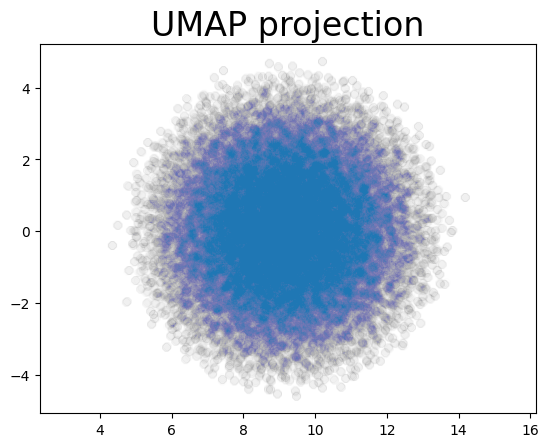

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], alpha=0.005)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection', fontsize=24);

### TCR-BERT Comparison

In [ ]:
from transformers import BertModel
tcrbert_model = BertModel.from_pretrained("wukevin/tcr-bert")

config.json:   0%|          | 0.00/2.64k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/230M [00:00<?, ?B/s]

In [ ]:
#!wget -c https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
#!chmod +x Miniconda3-4.5.4-Linux-x86_64.sh
#!bash ./Miniconda3-4.5.4-Linux-x86_64.sh -b -f -p /usr/local
!conda install anaconda-client
!conda env update --name=user/package -file=environments.yml

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - 

In [ ]:
df_tcrbert = pd.DataFrame()
df_tcrbert['trb'] = dataset['AASeq']
df_tcrbert.to_csv('tcr_bert_data.tsv', sep='\t')

In [ ]:
#!pip install anndata
#!pip install scanpy
#!pip install muscle
#!pip install biopython
#!pip install skorch
!pip install neptune
#!pip install neptune-cli --upgrade
!python embed_and_cluster.py tcr_bert_data.tsv

2023-11-21 20:58:45.050753: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-21 20:58:45.050798: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-21 20:58:45.050822: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-21 20:58:46.297557: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Traceback (most recent call last):
  File "/content/embed_and_cluster.py", line 19, in <module>
    import model_utils
  File "/content/model_utils.py", line 36, in <module>
    from neptune.experiments import Experiment
ModuleNotFoundErr

In [ ]:
import model_utils
net = model_utils.load_two_part_bert_classifier()

# Fine-Tuning (Hugging Face)

In [ ]:
!pip install evaluate
!pip install datasets

import os.path
#os.chdir("set a path here")


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from torch.utils.data import DataLoader

import re
import numpy as np
import pandas as pd
import copy

import transformers, datasets
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.t5.modeling_t5 import T5Config, T5PreTrainedModel, T5Stack
from transformers.utils.model_parallel_utils import assert_device_map, get_device_map
from transformers import T5EncoderModel, T5Tokenizer
from transformers import TrainingArguments, Trainer, set_seed
from transformers import DataCollatorForTokenClassification

from evaluate import load
from datasets import Dataset

from tqdm import tqdm
import random

from scipy import stats
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

In [ ]:
os.environ["RANK"] = "0"
os.environ["LOCAL_RANK"] = "0"
os.environ["WORLD_SIZE"] = "1"

In [ ]:
print("Torch version: ",torch.__version__)
print("Cuda version: ",torch.version.cuda)
print("Numpy version: ",np.__version__)
print("Pandas version: ",pd.__version__)
print("Transformers version: ",transformers.__version__)
print("Datasets version: ",datasets.__version__)

Torch version:  2.1.0+cu118
Cuda version:  11.8
Numpy version:  1.23.5
Pandas version:  1.5.3
Transformers version:  4.35.2
Datasets version:  2.15.0


In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/DataTest_5M_11_17.tsv', sep='\t')

In [ ]:
df = pd.DataFrame()
df['sequence'] = dataset['AASeq']

In [ ]:
labels_total = []
for seq in df['sequence']:
  labels = [ord(char.lower()) - 97 for char in seq]
  labels_total.append(labels)
df['labels'] = labels_total

In [ ]:
df.head(5)

,sequence,labels
0,CASSVGLAGGNNEQFF,"[2, 0, 18, 18, 21, 6, 11, 0, 6, 6, 13, 13, 4, ..."
1,CASSLVSSGVYNEQFF,"[2, 0, 18, 18, 11, 21, 18, 18, 6, 21, 24, 13, ..."
2,CASSLRSGGRRTDTQYF,"[2, 0, 18, 18, 11, 17, 18, 6, 6, 17, 17, 19, 3..."
3,CASSSKPGQGAGGANVLTF,"[2, 0, 18, 18, 18, 10, 15, 6, 16, 6, 0, 6, 6, ..."
4,CSVEIADGYTF,"[2, 18, 21, 4, 8, 0, 3, 6, 24, 19, 5]"


## LoRA Structure

In [ ]:
class LoRAConfig:
    def __init__(self):
        self.lora_rank = 4
        self.lora_init_scale = 0.01
        self.lora_modules = ".*SelfAttention|.*EncDecAttention"
        self.lora_layers = "q|k|v|o"
        self.trainable_param_names = ".*layer_norm.*|.*lora_[ab].*"
        self.lora_scaling_rank = 1
        # lora_modules and lora_layers are speicified with regular expressions
        # see https://www.w3schools.com/python/python_regex.asp for reference

class LoRALinear(nn.Module):
    def __init__(self, linear_layer, rank, scaling_rank, init_scale):
        super().__init__()
        self.in_features = linear_layer.in_features
        self.out_features = linear_layer.out_features
        self.rank = rank
        self.scaling_rank = scaling_rank
        self.weight = linear_layer.weight
        self.bias = linear_layer.bias
        if self.rank > 0:
            self.lora_a = nn.Parameter(torch.randn(rank, linear_layer.in_features) * init_scale)
            if init_scale < 0:
                self.lora_b = nn.Parameter(torch.randn(linear_layer.out_features, rank) * init_scale)
            else:
                self.lora_b = nn.Parameter(torch.zeros(linear_layer.out_features, rank))
        if self.scaling_rank:
            self.multi_lora_a = nn.Parameter(
                torch.ones(self.scaling_rank, linear_layer.in_features)
                + torch.randn(self.scaling_rank, linear_layer.in_features) * init_scale
            )
            if init_scale < 0:
                self.multi_lora_b = nn.Parameter(
                    torch.ones(linear_layer.out_features, self.scaling_rank)
                    + torch.randn(linear_layer.out_features, self.scaling_rank) * init_scale
                )
            else:
                self.multi_lora_b = nn.Parameter(torch.ones(linear_layer.out_features, self.scaling_rank))

    def forward(self, input):
        if self.scaling_rank == 1 and self.rank == 0:
            # parsimonious implementation for ia3 and lora scaling
            if self.multi_lora_a.requires_grad:
                hidden = F.linear((input * self.multi_lora_a.flatten()), self.weight, self.bias)
            else:
                hidden = F.linear(input, self.weight, self.bias)
            if self.multi_lora_b.requires_grad:
                hidden = hidden * self.multi_lora_b.flatten()
            return hidden
        else:
            # general implementation for lora (adding and scaling)
            weight = self.weight
            if self.scaling_rank:
                weight = weight * torch.matmul(self.multi_lora_b, self.multi_lora_a) / self.scaling_rank
            if self.rank:
                weight = weight + torch.matmul(self.lora_b, self.lora_a) / self.rank
            return F.linear(input, weight, self.bias)

    def extra_repr(self):
        return "in_features={}, out_features={}, bias={}, rank={}, scaling_rank={}".format(
            self.in_features, self.out_features, self.bias is not None, self.rank, self.scaling_rank
        )


def modify_with_lora(transformer, config):
    for m_name, module in dict(transformer.named_modules()).items():
        if re.fullmatch(config.lora_modules, m_name):
            for c_name, layer in dict(module.named_children()).items():
                if re.fullmatch(config.lora_layers, c_name):
                    assert isinstance(
                        layer, nn.Linear
                    ), f"LoRA can only be applied to torch.nn.Linear, but {layer} is {type(layer)}."
                    setattr(
                        module,
                        c_name,
                        LoRALinear(layer, config.lora_rank, config.lora_scaling_rank, config.lora_init_scale),
                    )
    return transformer

## Classification Model

In [ ]:
class ClassConfig:
    def __init__(self, dropout=0.2, num_labels=3):
        self.dropout_rate = dropout
        self.num_labels = num_labels

class T5EncoderForTokenClassification(T5PreTrainedModel):

    def __init__(self, config: T5Config, class_config):
        super().__init__(config)
        self.num_labels = class_config.num_labels
        self.config = config

        self.shared = nn.Embedding(config.vocab_size, config.d_model)

        encoder_config = copy.deepcopy(config)
        encoder_config.use_cache = False
        encoder_config.is_encoder_decoder = False
        self.encoder = T5Stack(encoder_config, self.shared)

        self.dropout = nn.Dropout(class_config.dropout_rate)
        self.classifier = nn.Linear(config.hidden_size, class_config.num_labels)

        # Initialize weights and apply final processing
        self.post_init()

        # Model parallel
        self.model_parallel = False
        self.device_map = None

    def parallelize(self, device_map=None):
        self.device_map = (
            get_device_map(len(self.encoder.block), range(torch.cuda.device_count()))
            if device_map is None
            else device_map
        )
        assert_device_map(self.device_map, len(self.encoder.block))
        self.encoder.parallelize(self.device_map)
        self.classifier = self.classifier.to(self.encoder.first_device)
        self.model_parallel = True

    def deparallelize(self):
        self.encoder.deparallelize()
        self.encoder = self.encoder.to("cpu")
        self.model_parallel = False
        self.device_map = None
        torch.cuda.empty_cache()

    def get_input_embeddings(self):
        return self.shared

    def set_input_embeddings(self, new_embeddings):
        self.shared = new_embeddings
        self.encoder.set_input_embeddings(new_embeddings)

    def get_encoder(self):
        return self.encoder

    def _prune_heads(self, heads_to_prune):
        """
        Prunes heads of the model. heads_to_prune: dict of {layer_num: list of heads to prune in this layer} See base
        class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            inputs_embeds=inputs_embeds,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]
        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss()

            active_loss = attention_mask.view(-1) == 1
            active_logits = logits.view(-1, self.num_labels)

            active_labels = torch.where(
              active_loss, labels.view(-1), torch.tensor(-100).type_as(labels)
            )

            valid_logits=active_logits[active_labels!=-100]
            valid_labels=active_labels[active_labels!=-100]

            valid_labels=valid_labels.type(torch.LongTensor).to('cuda:0')

            loss = loss_fct(valid_logits, valid_labels)


        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

## Modified ProtT5 model

In [ ]:
def PT5_classification_model(num_labels):
    # Load PT5 and tokenizer
    model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50")
    tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50")

    # Create new Classifier model with PT5 dimensions
    class_config=ClassConfig(num_labels=num_labels)
    class_model=T5EncoderForTokenClassification(model.config,class_config)

    # Set encoder and embedding weights to checkpoint weights
    class_model.shared=model.shared
    class_model.encoder=model.encoder

    # Delete the checkpoint model
    model=class_model
    del class_model

    # Print number of trainable parameters
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("ProtT5_Classfier\nTrainable Parameter: "+ str(params))

    # Add model modification lora
    config = LoRAConfig()

    # Add LoRA layers
    model = modify_with_lora(model, config)

    # Freeze Embeddings and Encoder (except LoRA)
    for (param_name, param) in model.shared.named_parameters():
                param.requires_grad = False
    for (param_name, param) in model.encoder.named_parameters():
                param.requires_grad = False

    for (param_name, param) in model.named_parameters():
            if re.fullmatch(config.trainable_param_names, param_name):
                param.requires_grad = True

    # Print trainable Parameter
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("ProtT5_LoRA_Classfier\nTrainable Parameter: "+ str(params) + "\n")

    return model, tokenizer

## DeepSpeed Config
